# CRITEO SPONSORED SEARCH CONVERSION LOG DATASET

## WHAT IS THIS NOTEBOOK ABOUT

This notebook presents EDA (Exploratory Data Analysis), elements of feature engineering and correlation test of the "CRITEO SPONSORED SEARCH CONVERSION LOG DATASET"

## CONTENTS

1. INTRODUCTION
2. EXPLORATORY DATA ANALYSIS
3. TESTING HYPOTHESES
4. FEATURE ENGINEERING
5. STATISTICAL TESTING OF DESCRIBING FEATURES
6. COMPETITION METRIC
7. SUMMARY
8. LITERATURE


# 1. INTRODUCTION

## DESCRIPTION OF THE DATASET

Criteo Sponsored Search Conversion Log Dataset contains logs obtained from Criteo Predictive Search. \
Each row in the dataset represents an action performed by the user on a product related advertisement. 

### Data description

- Sale : Indicates 1 if conversion occurred and 0 if not.
- SalesAmountInEuro : Indicates the revenue obtained when a conversion took place. This might be different from product-price, due to attribution issues. It is -1, when no conversion took place.
- Time_delay_for_conversion : This indicates the time between click and conversion. It is -1, when no conversion took place.

- click_timestamp: Timestamp of the click. The dataset is sorted according to timestamp.
- nb_clicks_1week: Number of clicks the product related advertisement has received in the last 1 week.
- product_price: Price of the product shown in the advertisement.
- product_age_group: The intended user age group of the user, the product is made for.
- device_type: This indicates whether it is a returning user or a new user on mobile, tablet or desktop. 
- audience_id:  We do not disclose the meaning of this feature.
- product_gender: The intended gender of the user, the product is made for.
- product_brand: Categorical feature about the brand of the product.
- product_category(1-7): Categorical features associated to the product. We do not disclose the meaning of these features.
- product_country: Country in which the product is sold.
- product_id: Unique identifier associated with every product.
- product_title: Hashed title of the product.
- partner_id: Unique identifier associated with the seller of the product.
- user_id: Unique identifier associated with every user.

**All categorical features have been hashed**, **-1 is the missing value indicator**

For more information about the dataset head over to https://ailab.criteo.com/criteo-sponsored-search-conversion-log-dataset/

## IMPORTS FOR THE NOTEBOOK

In [1]:
import os
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:.3f}'.format

from scipy.stats import moment
from scipy.stats import t

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
import seaborn as sns


%matplotlib inline

## CONSTANTS
Constants that will be used later in the notebook

In [2]:
PARTNER_ID = 'BD01BAFAE73CF38C403978BBB458300C'

ALL_COLUMN_NAMES = ['Sale', 'SalesAmountInEuro', 'time_delay_for_conversion', 'click_timestamp',
                    'nb_clicks_1week', 'product_price', 'product_age_group', 'device_type',
                    'product_gender', 'product_brand','product_category(1)', 'product_category(2)',
                    'product_category(3)', 'product_category(4)','product_category(5)',
                    'product_category(6)', 'product_category(7)', 'product_country', 'product_id',
                    'product_title', 'partner_id', 'user_id']

OBJECT_TYPE_COLUMN_NAMES = ['product_age_group', 'device_type','audience_id', 'product_gender', 'product_brand',
                       'product_category(1)', 'product_category(2)', 'product_category(3)', 'product_category(4)',
                       'product_category(5)', 'product_category(6)', 'product_category(7)',
                       'product_country', 'product_id', 'product_title', 'user_id']

## CREATE CSV - CHOOSE THE PARTNER_ID

The analysis will be performed only for one of many *partner_id* from the dataset. Because the dataset can be considered a big data source, we have created a csv file containing only the information related to chosen ` PARTNER_ID `.

In [ ]:
%run create_csv_file.py

## READ CSV

In [4]:
filepath = f"CriteoSearchData_{PARTNER_ID}.csv"

if os.path.isfile(filepath):
    df_raw = pd.read_csv(f"CriteoSearchData_{PARTNER_ID}.csv", low_memory=False, usecols=ALL_COLUMN_NAMES)
else:
    print('Sorry. You have to create an appropriate csv file first.')

# drop partner_id column -> same for every row
df_raw.drop(labels='partner_id', inplace=True, axis=1)

Before performing EDA, let's preprocess the data - handle NaNs and hashed values.

First of all let's change all the `-1` values in the dataset to `np.NaN` to a indicate missing value.

## PREPROCESSING

In [5]:
# handle NANs
df_nans = df_raw.replace('-1', np.NaN)
df_nans.replace(-1, np.NaN, inplace=True)

# Filter Sales
df_nans_sale_1 = df_nans.query("Sale == 1")

Now let's handle the hashed values. First of all let's check datatypes of the columns of `df`

In [6]:
print(df_nans_sale_1.dtypes)
print('-'*30)
print(df_nans_sale_1.dtypes.value_counts())

Sale                           int64
SalesAmountInEuro            float64
time_delay_for_conversion    float64
click_timestamp                int64
nb_clicks_1week              float64
product_price                float64
product_age_group             object
device_type                   object
product_gender                object
product_brand                 object
product_category(1)           object
product_category(2)           object
product_category(3)           object
product_category(4)           object
product_category(5)           object
product_category(6)           object
product_category(7)          float64
product_country               object
product_id                    object
product_title                 object
user_id                       object
dtype: object
------------------------------
object     14
float64     5
int64       2
dtype: int64


Thanks to this summary we know now that 16 features have `object` type which means they have been hashed. We can simplify every column with `object` type. As long as they are hashed, we do not lose any valuable information (however we will store the original data in a dictionary `encoders`) and what is more - it will simplify the EDA of the dataset later. \
For example we will transform the `product_gender` column by assigning one number for each category. \
To achieve this we will use `LabelEncoder` from `sklearn.preprocessing` package.

In [7]:
df_nans_encoded = pd.DataFrame()
encoders = {}

for col in df_nans.columns:
    if col in OBJECT_TYPE_COLUMN_NAMES:
        encoder = LabelEncoder()
        # filter not null values from the column
        series_not_null = df_nans_sale_1[col][df_nans_sale_1[col].notnull()]
        # transform the values using LabelEncoder
        df_nans_encoded[col] = pd.Series(encoder.fit_transform(series_not_null), index=series_not_null.index)
        # save the encoder
        encoders[col] = encoder
    else:
        df_nans_encoded[col] = df_nans_sale_1[col]

df_nans_encoded.head(3)

,Sale,SalesAmountInEuro,time_delay_for_conversion,click_timestamp,nb_clicks_1week,product_price,product_age_group,device_type,product_gender,product_brand,...,product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_category(7),product_country,product_id,product_title,user_id
7,1,119.000,457035.000,1598898651,19.000,119.000,0.000,1,0.000,852.000,...,3.000,15.000,NaN,NaN,NaN,NaN,0,1354,1412.000,2347
12,1,53.000,457.000,1598919368,3.000,53.000,2.000,0,0.000,659.000,...,13.000,NaN,NaN,NaN,NaN,NaN,0,2179,804.000,1520
35,1,178.000,101671.000,1598903859,0.000,89.000,0.000,1,2.000,396.000,...,6.000,27.000,NaN,NaN,NaN,NaN,0,317,1010.000,970


## CREATE FINAL DATASET

In [8]:
df_nans_encoded.click_timestamp = pd.to_datetime(df_nans_encoded.click_timestamp, unit='s', origin='unix')
df_nans_encoded['day'] = df_nans_encoded.click_timestamp.dt.date
df = df_nans_encoded.groupby(['day', 'product_id']).agg({'Sale' : 'size',
                                                         'SalesAmountInEuro': 'sum',
                                                         'time_delay_for_conversion': 'mean',
                                                         'nb_clicks_1week': 'mean',
                                                         'product_price': ['sum', 'mean'],
                                                         'product_age_group': 'mean', 
                                                         'device_type': 'mean', 
                                                         'product_gender': 'mean',
                                                         'product_brand': 'mean', 
                                                         'product_category(1)': 'mean', 
                                                         'product_category(2)': 'mean', 
                                                         'product_category(3)': 'mean', 
                                                         'product_category(4)': 'mean', 
                                                         'product_category(5)': 'mean', 
                                                         'product_category(6)': 'mean', 
                                                         'product_category(7)': 'mean', 
                                                         'product_country': 'mean', 
                                                         'product_title': 'mean'})

df.reset_index(inplace=True)
df.columns = ['_'.join(temp).strip('_') for temp in df.columns.to_flat_index()]
df.dropna(subset=['time_delay_for_conversion_mean'], inplace=True)
df['time_delay_minutes'] = df.time_delay_for_conversion_mean / 60
df['time_delay_hours'] = df.time_delay_minutes / 60
df['time_delay_days'] = df.time_delay_hours / 24
df.head(8)

,day,product_id,Sale_size,SalesAmountInEuro_sum,time_delay_for_conversion_mean,nb_clicks_1week_mean,product_price_sum,product_price_mean,product_age_group_mean,device_type_mean,...,product_category(3)_mean,product_category(4)_mean,product_category(5)_mean,product_category(6)_mean,product_category(7)_mean,product_country_mean,product_title_mean,time_delay_minutes,time_delay_hours,time_delay_days
0,2020-08-04,1068,2,580.000,57369.000,0.000,290.000,145.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,0.000,1895.000,956.150,15.936,0.664
1,2020-08-04,2326,2,228.000,986.000,0.000,228.000,114.000,0.000,1.000,...,42.000,NaN,NaN,NaN,NaN,0.000,583.000,16.433,0.274,0.011
2,2020-08-05,19,2,254.000,105006.000,3.000,254.000,127.000,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,0.000,260.000,1750.100,29.168,1.215
3,2020-08-05,32,2,178.000,479.000,5.000,178.000,89.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,0.000,1038.000,7.983,0.133,0.006
4,2020-08-05,132,2,194.000,479925.000,1.000,194.000,97.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,0.000,211.000,7998.750,133.312,5.555
5,2020-08-05,580,2,380.000,1643.000,26.000,380.000,190.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,0.000,357.000,27.383,0.456,0.019
6,2020-08-05,682,2,250.000,424.000,0.000,190.000,95.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,0.000,1304.000,7.067,0.118,0.005
7,2020-08-05,734,2,300.000,85069.000,0.000,152.000,76.000,0.000,1.000,...,15.000,NaN,NaN,NaN,NaN,0.000,1328.000,1417.817,23.630,0.985


# 2. EXPLORATORY DATA ANALYSIS

This part of the notebook presents EDA performed on the FINAL DATASET created earlier.
## Summary statistics
First of all we will calculate statistics for column `product_price_mean`

Summary statistics:
- Mean
- Median
- Variance
- Standard deviation
- Skewness
- Kurtosis
- 0, 0.25, 0.5, 0.75, 1 Quantiles
- IQR

In [9]:
price = df['product_price_mean']

summary_statistics = pd.DataFrame({
    'product_price_mean': [price.mean(),
                          price.median(),
                          price.var(ddof=0),
                          price.std(ddof=0),
                          moment(price, 3)/(moment(price, 2)**(3/2)),
                          moment(price, 4)/(moment(price, 2))**2,
                           price.quantile(0),
                          price.quantile(0.25),
                          price.quantile(0.5),
                          price.quantile(0.75),
                           price.quantile(1),
                          price.quantile(0.75) - price.quantile(0.25)]},
    index=['mean', 'median', 'variance', 'std', 'skewness', 'kurtosis', '0.0', '0.25', '0.5', '0.75', '1.0', 'IQR'])

summary_statistics

,product_price_mean
mean,111.103
median,85.000
variance,9091.755
std,95.351
skewness,2.872
kurtosis,15.460
0.0,14.000
0.25,53.000
0.5,85.000
0.75,131.000


Thanks to this short summary of the most important descriptive statistics, you can see that the values are close to $ 200-300, but there are also significant outliers.

## Frequency

A frequency distribution table is an arrangement of the values that one or more variables take in a sample. Each entry in the table contains the frequency or count of the occurrences of values within a particular group or interval, and in this way, the table summarizes the distribution of values in the sample.


The resolution series for the 'product_price_mean' column, which represents the average price for a given product on a given day, is shown below. The whole data series was divided into 25 bins and the number of values in each of them was counted. As you can see, the most values are in the first 3 bins, then the amount gradually decreases. Users are most likely to purchase iteams and products that are between ` $0 ` and ` $150 ` in the price range.

The presented division into bins confirms what was observed in the previous point. Most of the values are close together, however there are outliers.

In [10]:
freq_table = df.groupby(pd.cut(df.product_price_mean, 25)).size()
freq_table

product_price_mean
(12.974, 55.04]     721
(55.04, 96.08]      827
(96.08, 137.12]     471
(137.12, 178.16]    221
(178.16, 219.2]     137
(219.2, 260.24]      76
(260.24, 301.28]     58
(301.28, 342.32]     29
(342.32, 383.36]     33
(383.36, 424.4]      11
(424.4, 465.44]      11
(465.44, 506.48]     12
(506.48, 547.52]      2
(547.52, 588.56]      5
(588.56, 629.6]       5
(629.6, 670.64]       5
(670.64, 711.68]      3
(711.68, 752.72]      2
(752.72, 793.76]      1
(793.76, 834.8]       0
(834.8, 875.84]       0
(875.84, 916.88]      0
(916.88, 957.92]      0
(957.92, 998.96]      0
(998.96, 1040.0]      1
dtype: int64

Thanks to this frequency table, we can observe that there is one outlier. To make further data analysis easier and more transparent (histogram), we will filter it out from the data set.

In [11]:
df = df.query("product_price_mean < 800")

## Histogram

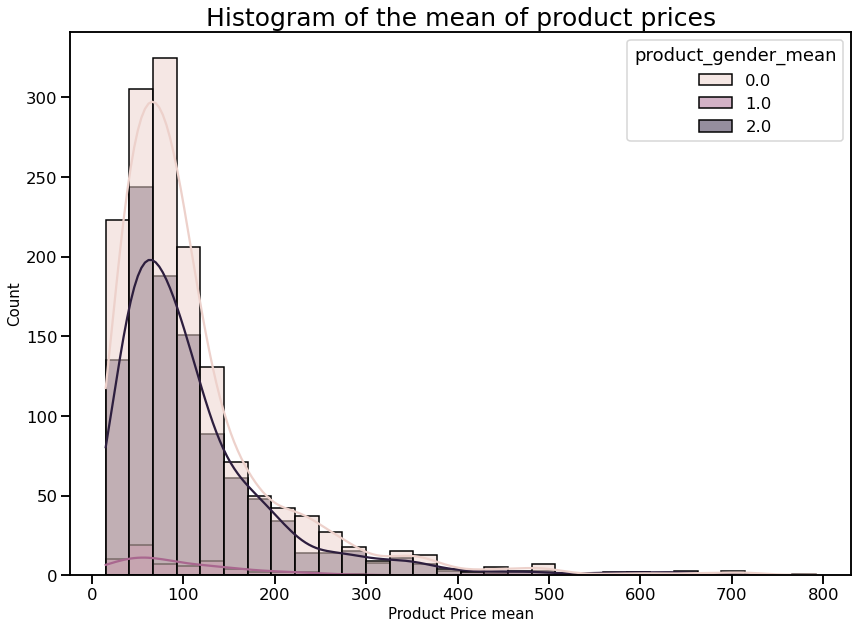

In [12]:
plt.figure(figsize=(14, 10))

sns.set_context('talk')
sns.histplot(data=df, x='product_price_mean', bins=30, hue='product_gender_mean', kde=True)
plt.title("Histogram of the mean of product prices", fontsize=25)
plt.xlabel("Product Price mean", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

The above histogram shows the distribution of the quantity of average product prices divided by the sex of the person making the purchase (hue). We can observe that the graph looks similar for each group. Regardless of gender, most values are in the ` $ 0 ` - ` $ 150 ` range. Users are reluctant to buy more expensive products. As the price increases, the number of values belonging to each bin decreases.

## Box plot

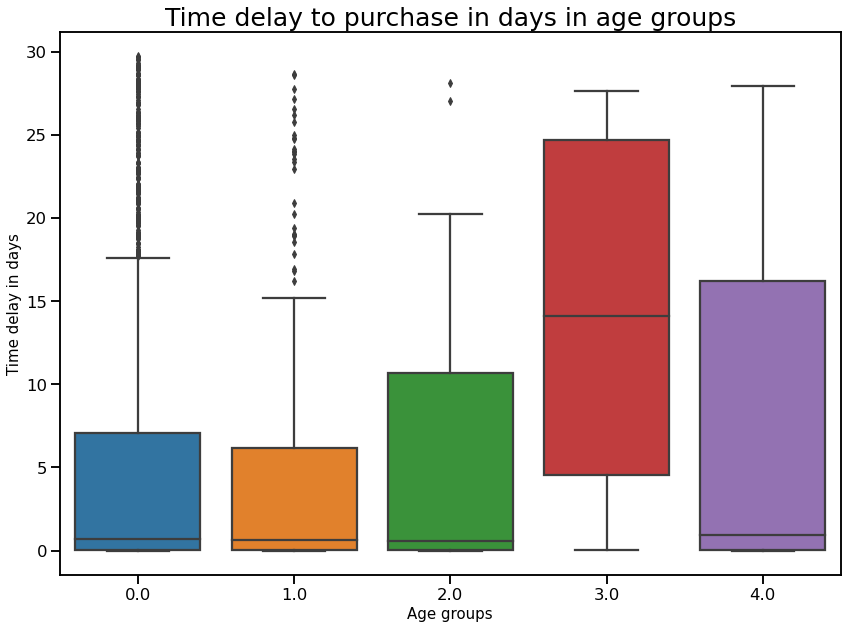

In [13]:
plt.figure(figsize=(14, 10))

sns.set_context("talk")
sns.boxplot(x='product_age_group_mean', y='time_delay_days', data=df)
plt.title("Time delay to purchase in days in age groups", fontsize=25)
plt.xlabel("Age groups", fontsize=15)
plt.ylabel("Time delay in days", fontsize=15)
plt.show()

The above box chart shows the time between clicking on the ad and becoming a customer in the store by purchasing the product. Time is expressed in days. For four of the five groups, the median waiting time is approximately less than a day. For groups no. 0 and no. 1, a lot of outliers can be observed. The group no.3 differs most from the other groups, for which the median of this value is almost 15 days, and also the 1st and 3rd quartiles are significantly different from the other observed groups.


Thanks to this chart, it can be concluded that people from group 3 make purchases more responsibly than the rest - they spend more time checking the product and do not make purchases on the spur of the moment.

It is also worth checking how many people belong to each group. For this we will use a bar chart.

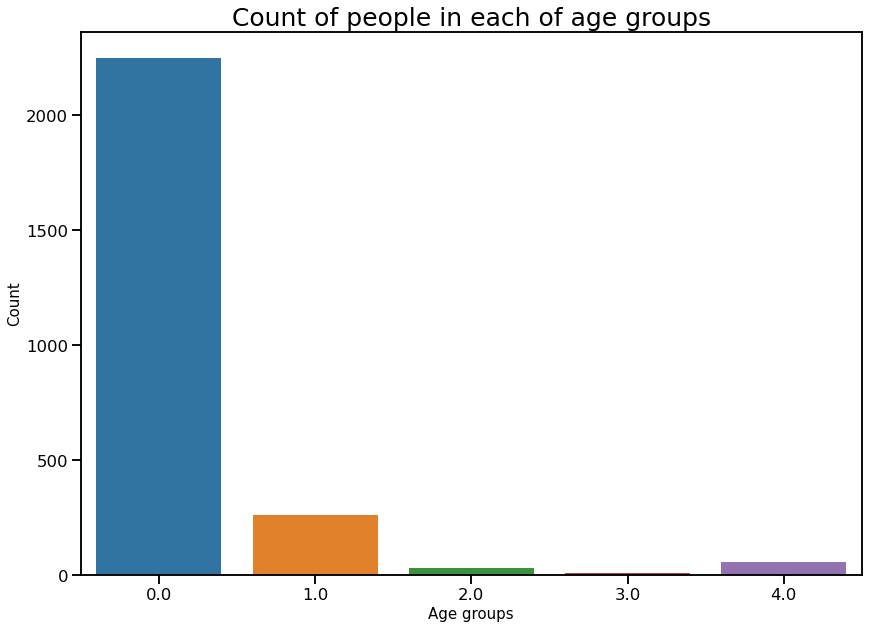

In [14]:
plt.figure(figsize=(14, 10))

sns.set_context("talk")
sns.countplot(x='product_age_group_mean', data=df)
plt.title("Count of people in each of age groups", fontsize=25)
plt.xlabel("Age groups", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

The bar chart presented above slightly changes the perception of the previous plot - the box plot. It turns out that comparing delay times in different age groups may be a bit unreliable due to the large difference in the number of people in each group. Definitely most people belong to the zero group, and the least to the third group. This may be one of the reasons for the previously observed differences in time between clicking and becoming a customer.

# 3. TESTING HYPOTHESES

The higher the price of the product, the higher the cost for the user. Hence, the user should consider whether it is really profitable to spend money. So the time between clicking on the ad and buying an item should be longer for more expensive items.

The first test to be carried out will therefore be the test for the correlation of the variables time_delay_days and product_price_mean.

In [15]:
time = df.time_delay_days
price = df.product_price_mean
alpha = 0.05
n = len(time)

covariance = np.cov(time, price, ddof=1)[0, 1]
correlation = covariance/(np.std(time, ddof=1)*np.std(price, ddof=1))

print(f'Covariance: {covariance:.3f}')
print(f'Correlation: {correlation:.3f}')

crit_value = t.ppf(1-alpha/2, n-2)
T = correlation*np.sqrt(n-2) / np.sqrt(1 - correlation**2)
print(f'Critical value: {crit_value:.3f}')
print(f't value: {T:.3f}')

Covariance: 40.675
Correlation: 0.057
Critical value: 1.961
t value: 2.948


We can observe that although the correlation is not zero, its value is very close to zero. This means that the linear relationship between these variables is very low. For a better understanding, let's plot these two variables using a scatter plot.

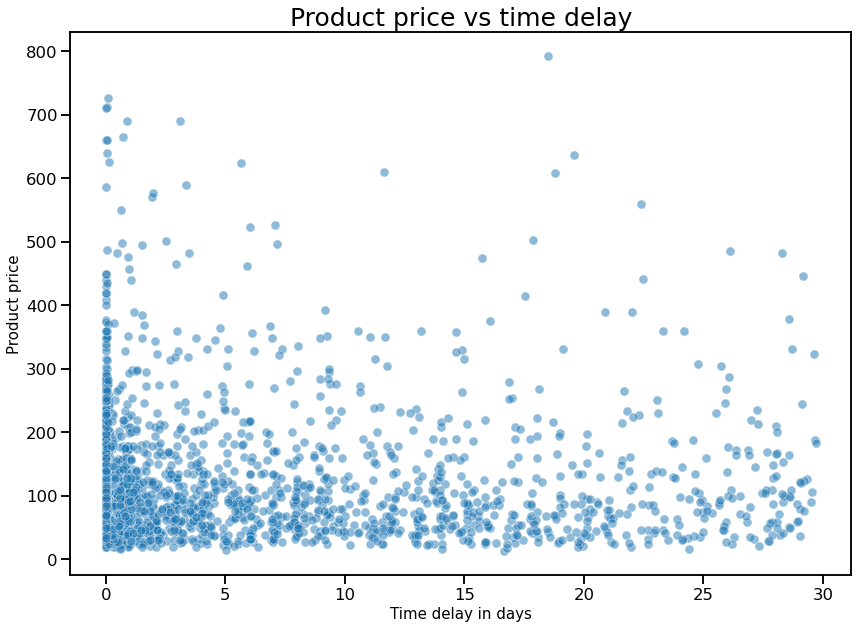

In [67]:
plt.figure(figsize=(14, 10))

sns.set_context("talk")
sns.scatterplot(x='time_delay_days', y='product_price_mean', data=df, alpha=0.5)
plt.title("Product price vs time delay", fontsize=25)
plt.xlabel("Time delay in days", fontsize=15)
plt.ylabel("Product price", fontsize=15)
plt.show()

The chart clearly shows that, virtually regardless of the price of the product, in most cases the purchase is made immediately.

# 4. FEATURE ENGINEERING

# 5. STATISTICAL TESTING OF DESCRIBING FEATURES

# 6. COMPETITION METRIC

# 7. SUMMARY

# 8. LITERATURE

1. https://en.wikipedia.org/wiki/Frequency_(statistics)
2. https://en.wikipedia.org/wiki/Exploratory_data_analysis
3. https://en.wikipedia.org/wiki/Summary_statistics